In [2]:
import kagglehub
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
from networkx.algorithms.community import louvain_communities
from collections import Counter
import re
from collections import defaultdict



/Users/karenstentoft/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create graph

In [3]:
df = pd.read_csv("Merged_data.csv")

In [4]:
# Creating the graph
G = nx.Graph()

for i in range(len(df)):
    G.add_node(df['Title'][i],
    release_year = int(df['Released_Year'][i]) if not pd.isna(df['Released_Year'][i]) else None,
    runtime = int((df['Runtime'][i]).replace(' min', '')),
    genre = (df['Genre'][i]).replace(" ", "").split(','),
    imdb_rating = float(df['imdb_rating'][i]),
    description = df['Description'][i],
    director = df['Director'][i],
    stars = [df['Star1'][i], df['Star2'][i], df['Star3'][i], df['Star4'][i]],
    imdb_no_of_votes = int(df['imdb_no_of_votes'][i]),
    gross = int((df['Gross'][i]).replace(',', '')) if not pd.isna(df['Gross'][i]) else None,
    imdb_id = df["imdb_id"][i],
    gl_id = df["gl_id"][i],
    gl_user_id_tags = df["gl_user_id_tags"][i],
    gl_tag = df["gl_tag"][i],
    gl_user_id_ratings = df["gl_user_id_ratings"][i],
    gl_rating = df["gl_rating"][i]
    )

print(G)



Graph with 781 nodes and 0 edges


In [6]:
# Adding edges between movies who share stars
titles = list(df['Title'])
stars_list = df[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()

for i in range(len(titles)):
    for j in range(i + 1, len(titles)):
        if set(stars_list[i]) & set(stars_list[j]):
            G.add_edge(titles[i], titles[j])

print(G)
print(list(G.degree()))

Graph with 781 nodes and 2423 edges
[('The Shawshank Redemption', 9), ('The Godfather', 19), ('The Dark Knight', 17), ('The Godfather: Part II', 32), ('12 Angry Men', 8), ('The Lord of the Rings: The Return of the King', 10), ('Pulp Fiction', 12), ("Schindler's List", 7), ('Inception', 15), ('Fight Club', 16), ('The Lord of the Rings: The Fellowship of the Ring', 7), ('Forrest Gump', 15), ('The Lord of the Rings: The Two Towers', 10), ('The Matrix', 2), ('Goodfellas', 18), ('Star Wars: Episode V - The Empire Strikes Back', 8), ("One Flew Over the Cuckoo's Nest", 5), ('Hamilton', 0), ('Interstellar', 8), ('Saving Private Ryan', 23), ('The Green Mile', 14), ('Se7en', 20), ('The Silence of the Lambs', 6), ('Star Wars', 12), ("It's a Wonderful Life", 12), ('Joker', 20), ('Whiplash', 4), ('The Intouchables', 0), ('The Prestige', 27), ('The Departed', 26), ('The Pianist', 1), ('Gladiator', 10), ('American History X', 7), ('The Usual Suspects', 6), ('Léon', 8), ('The Lion King', 3), ('Termina

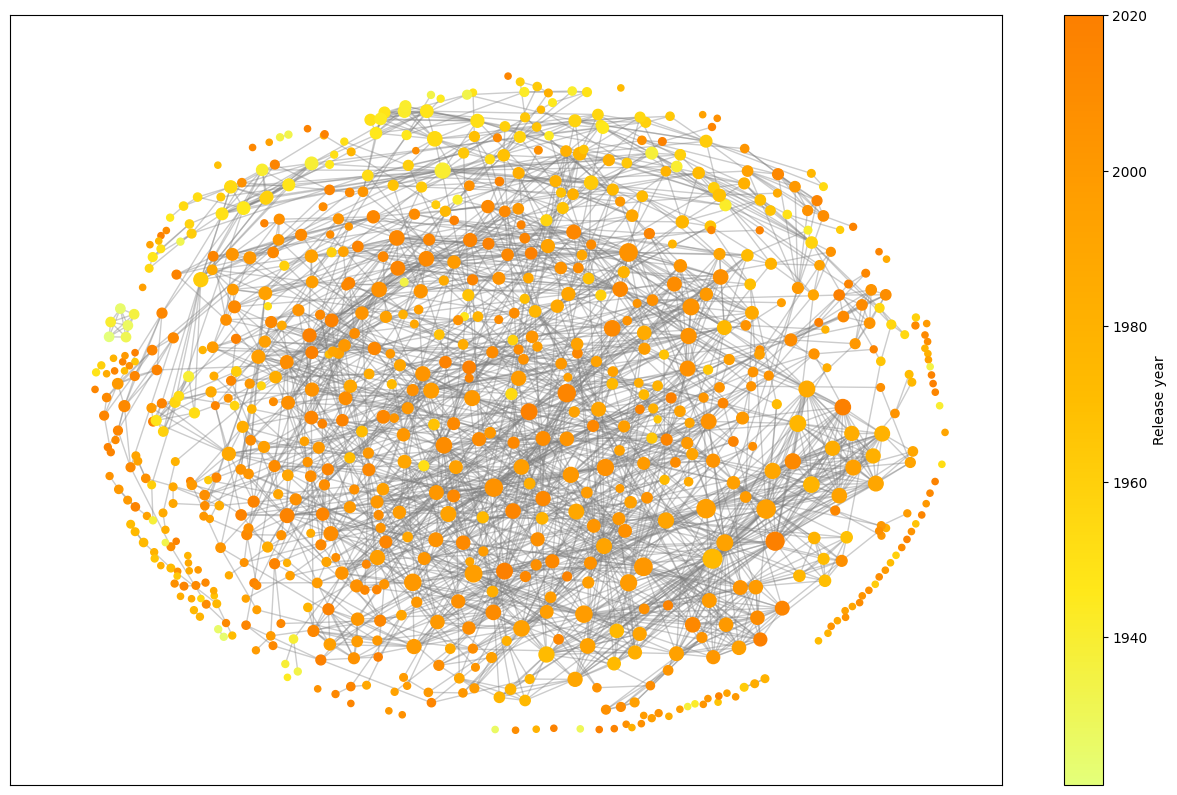

In [7]:
plt.style.use('default')

# Find node size
degrees = dict(G.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G.nodes()]

pos = nx.forceatlas2_layout(G, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Wistia, alpha=1)
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [8]:
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes:", {len(isolated_nodes)})
G_no_isolates = G.copy()
G_no_isolates.remove_nodes_from(isolated_nodes)

Number of isolated nodes: {102}


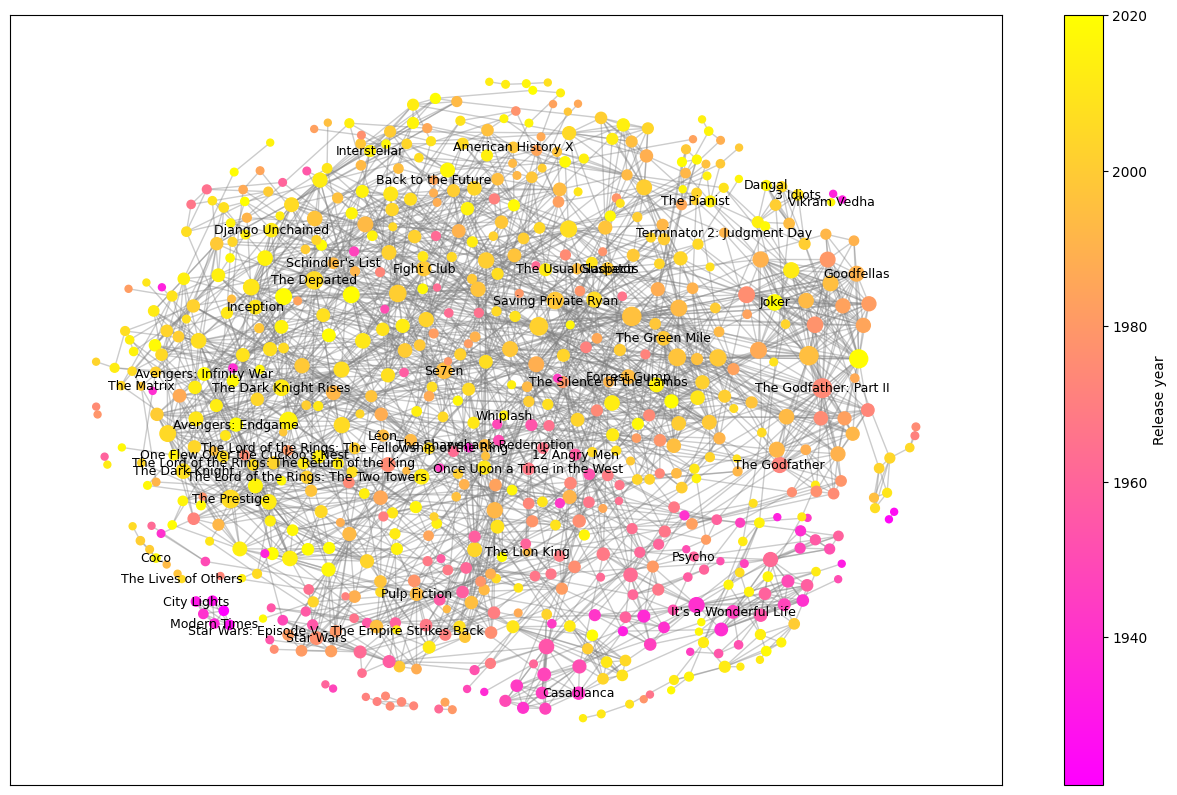

In [9]:
plt.style.use('default')

# # Find node size
degrees = dict(G_no_isolates.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G_no_isolates.nodes()]

pos = nx.forceatlas2_layout(G_no_isolates, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_no_isolates, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_no_isolates, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G_no_isolates, pos, labels, font_size=9, font_weight='normal') 

random_nodes = list(degrees.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_no_isolates, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [10]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G_largest = G.subgraph(Gcc[0])
print(G_largest)

Graph with 641 nodes and 2384 edges


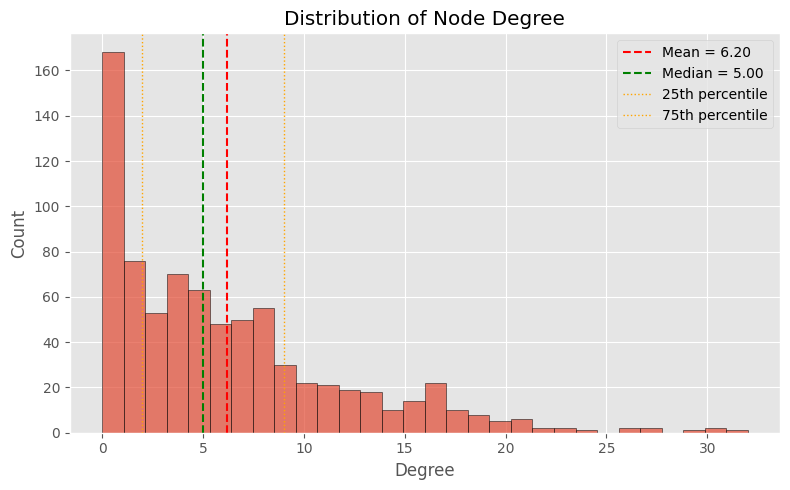

In [11]:
# Degree distribution of original graph

plt.style.use("ggplot")

degree_vals = [deg for _, deg in G.degree()]

mean_deg = np.mean(degree_vals)
median_deg = np.median(degree_vals)
var_deg = np.var(degree_vals)
p25 = np.percentile(degree_vals, 25)
p75 = np.percentile(degree_vals, 75)
min = np.min(degree_vals)
max = np.max(degree_vals)

plt.figure(figsize=(8,5))
plt.hist(degree_vals, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_deg, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_deg:.2f}")
plt.axvline(median_deg, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_deg:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Node Degree")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

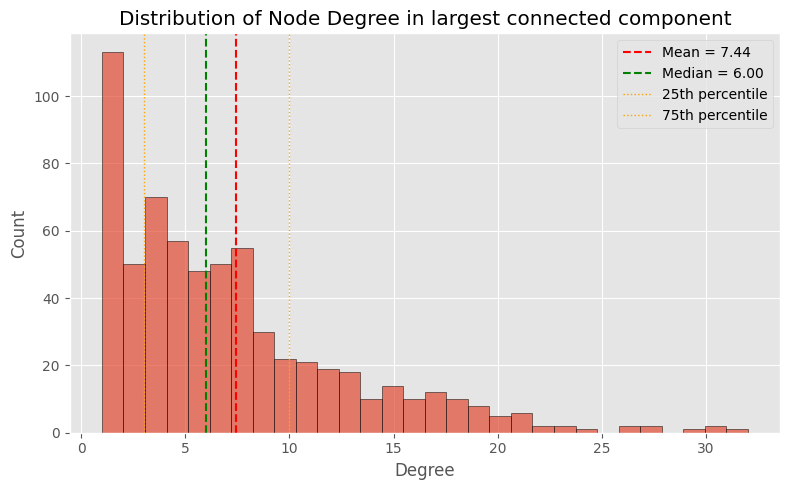

In [12]:
# Degree distribution of largest component

plt.style.use("ggplot")

degree_vals = [deg for _, deg in G_largest.degree()]

mean_deg = np.mean(degree_vals)
median_deg = np.median(degree_vals)
var_deg = np.var(degree_vals)
p25 = np.percentile(degree_vals, 25)
p75 = np.percentile(degree_vals, 75)
min = np.min(degree_vals)
max = np.max(degree_vals)

plt.figure(figsize=(8,5))
plt.hist(degree_vals, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_deg, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_deg:.2f}")
plt.axvline(median_deg, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_deg:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Node Degree in largest connected component")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

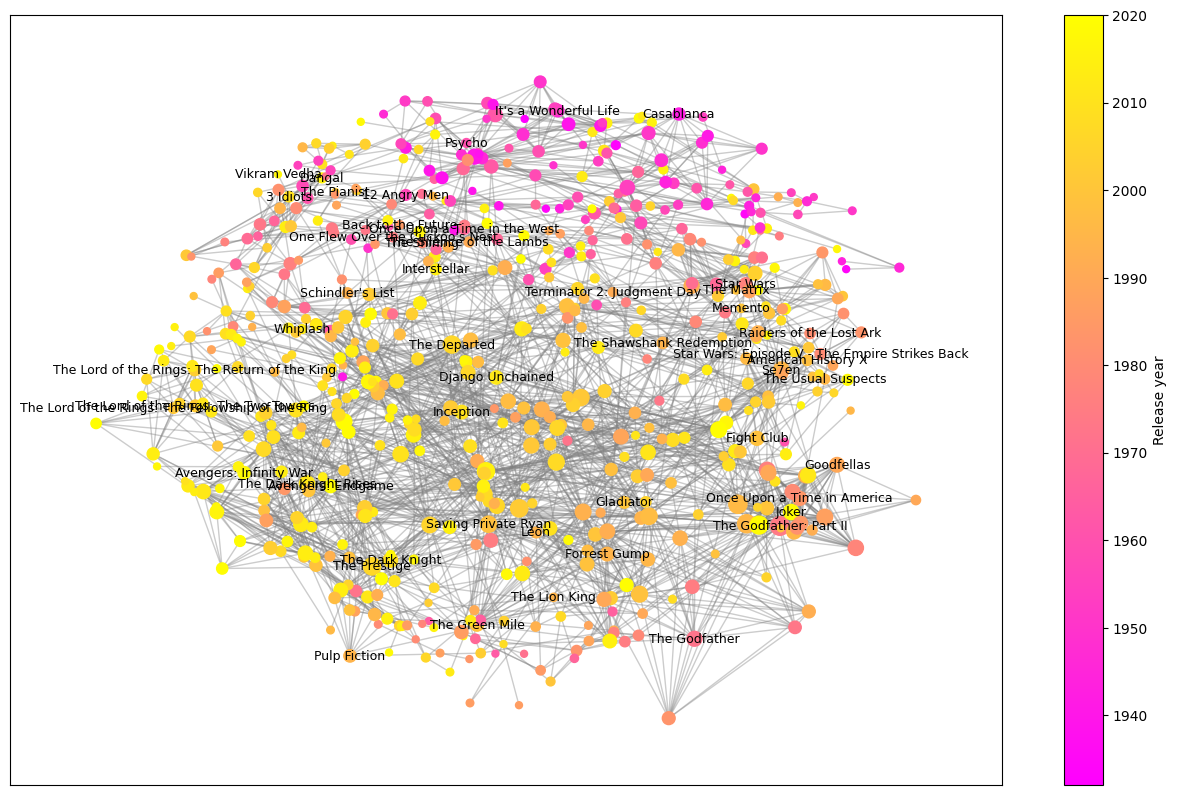

In [14]:
plt.style.use('default')

# # Find node size
degrees = dict(G_largest.degree())
node_sizes = [20 + deg * 5 for deg in degrees.values()] 

# Node colors
release_year = nx.get_node_attributes(G, "release_year")
node_colors = [release_year.get(n, 0) for n in G_largest.nodes()]

pos = nx.forceatlas2_layout(G_largest, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_largest, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_largest, pos, edge_color="gray", alpha=0.4)

# top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
# labels = {n: n for n in top_nodes}
# nx.draw_networkx_labels(G_largest, pos, labels, font_size=9, font_weight='normal') 

random_nodes = list(degrees.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_largest, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()

In [13]:
# Communities

louv_comm = louvain_communities(G_largest, seed=42)
print(f"Number of communities: {len(louv_comm)}")

M_louvain = nx.community.modularity(G_largest, louv_comm)
print(f"Modularity (Louvain communities): {M_louvain:.4f}")

Number of communities: 15
Modularity (Louvain communities): 0.6818


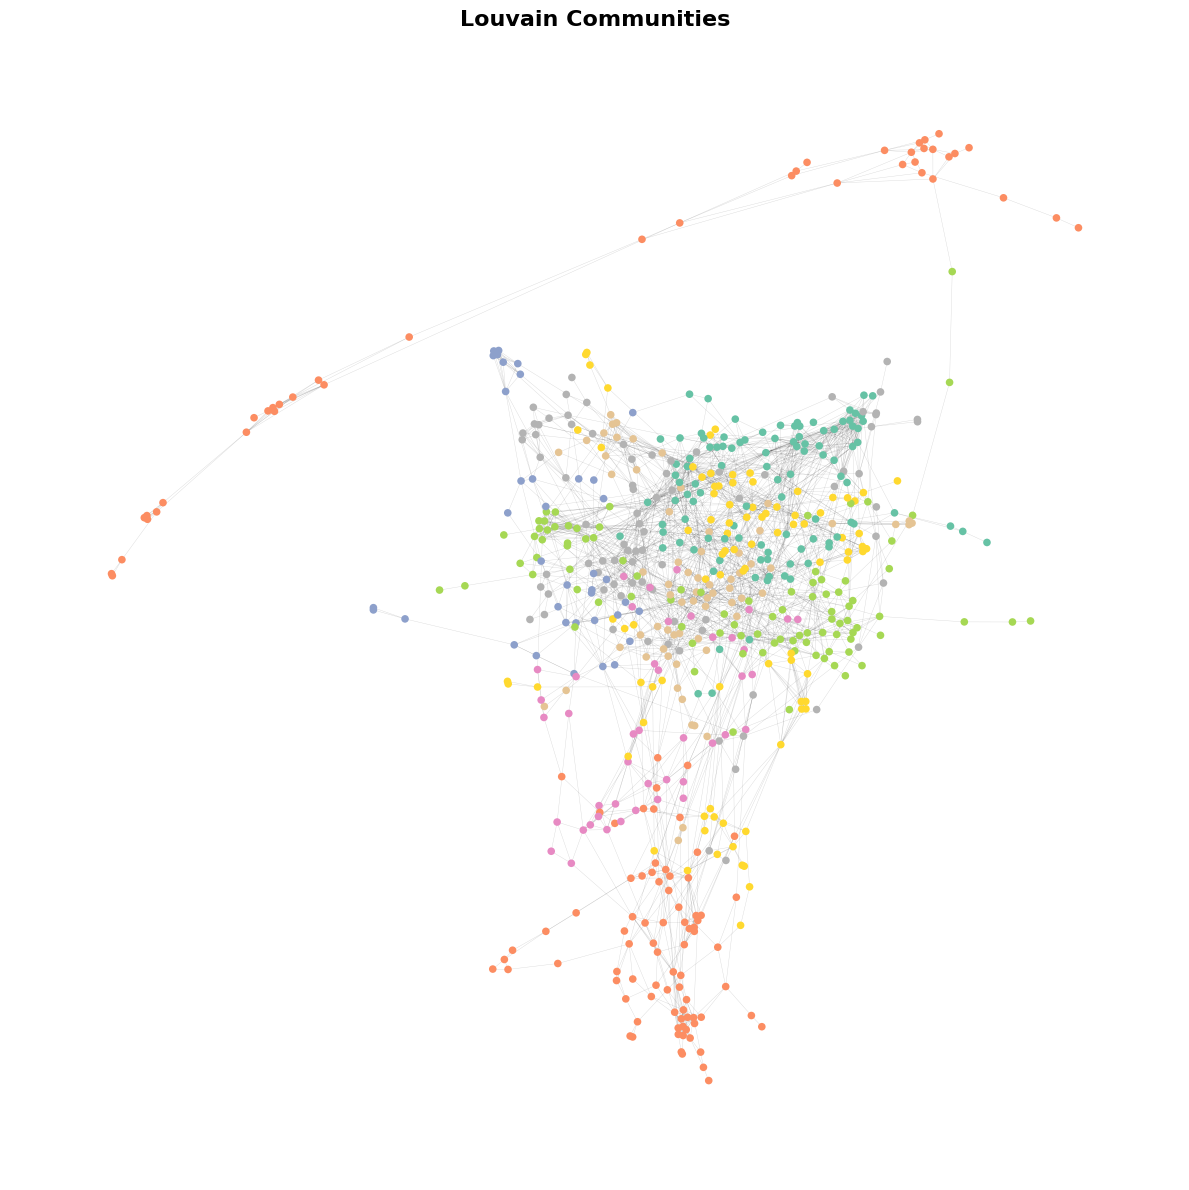

In [17]:
pos = nx.forceatlas2_layout(G, gravity=1.0, seed=42)

top_nodes = set().union(*louv_comm)

# Coloring
colors = plt.cm.Set2(np.linspace(0, 1, len(louv_comm)))
color_map = {}
for i, comm in enumerate(louv_comm):
    for node in comm:
        color_map[node] = colors[i]

node_colors = [color_map.get(n, (0.8, 0.8, 0.8, 0.25)) for n in G_largest.nodes()]

# Plot
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G_largest, pos, alpha=0.15, width=0.3, edge_color="black")
nx.draw_networkx_nodes(
    G_largest,
    pos,
    node_size=30,
    node_color=node_colors,
    linewidths=0.1,
    edgecolors="none",
)
plt.title("Louvain Communities", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

In [18]:
# Community info

deg_cent = nx.degree_centrality(G_largest)

community_info = []

for i, comm in enumerate(louv_comm):
    comm_deg = {n: deg_cent[n] for n in comm}
    top3 = sorted(comm_deg.items(), key=lambda x: x[1], reverse=True)[:3]
    top3_movies = [n.replace("_", " ") for n, _ in top3]

    all_genres = []
    for node in comm:
        g = G_largest.nodes[node].get("genre")
        all_genres.extend(g)
    common_genres = [g for g, _ in Counter(all_genres).most_common(1)]

    community_info.append({
        "Community": f"C{i}",
        "Top movies": ", ".join(top3_movies),
        "Top genres": ", ".join(common_genres),
    })

community_df = pd.DataFrame(community_info)

community_df

,Community,Top movies,Top genres
0,C0,"Ocean's Eleven, Se7en, The Big Lebowski",Drama
1,C1,"The Godfather: Part II, Sleepers, Heat",Drama
2,C2,"The Philadelphia Story, Sabrina, The Man Who S...",Drama
3,C3,"PK, Life of Pi, Dil Chahta Hai",Drama
4,C4,"Magnolia, A Few Good Men, Edge of Tomorrow",Drama
5,C5,"Harry Potter and the Deathly Hallows: Part 1, ...",Adventure
6,C6,"JFK, All the President's Men, Cat on a Hot Tin...",Drama
7,C7,"Catch Me If You Can, Saving Private Ryan, Phil...",Drama
8,C8,"Zodiac, The Avengers, Her",Drama
9,C9,"Blade Runner 2049, The Fugitive, Star Wars",Drama


In [19]:
# Backbone
def backbone_low_betweenness(G_largest, n_remove):
    # Work on a copy
    Gb = G_largest.copy()

    # Compute edge betweenness
    ebc = nx.edge_betweenness_centrality(Gb)

    # Sort edges: lowest betweenness first
    edges_sorted = sorted(ebc.items(), key=lambda x: x[1])

    # Select lowest n_remove edges
    edges_to_remove = [edge for edge, score in edges_sorted[:n_remove]]

    # Remove edges
    Gb.remove_edges_from(edges_to_remove)

    # Remove isolated nodes
    isolated = list(nx.isolates(Gb))
    Gb.remove_nodes_from(isolated)

    return Gb


# --- Run ---
G_backbone = backbone_low_betweenness(G_largest, n_remove=int(G_largest.number_of_edges()*0.85))


print("Nodes:", G_backbone.number_of_nodes())
print("Edges:", G_backbone.number_of_edges())

Nodes: 316
Edges: 358


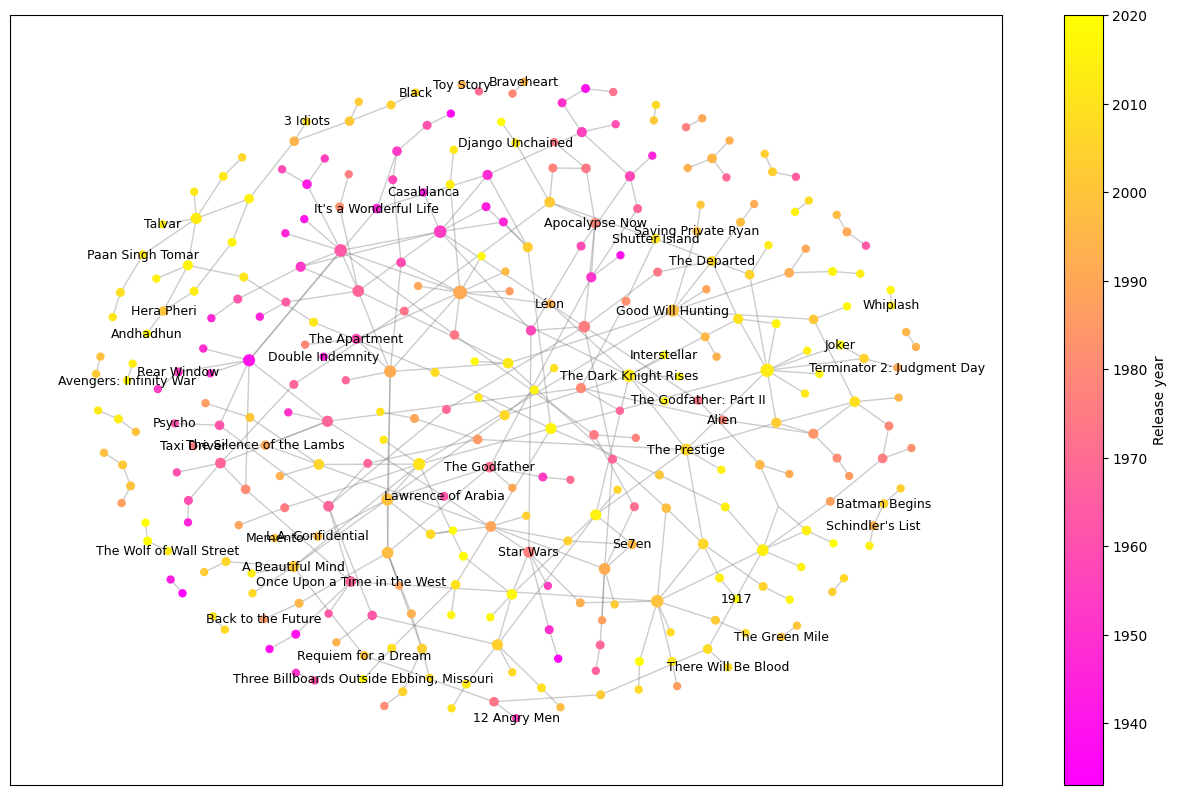

In [20]:
# # Find node size
degrees_backbone = dict(G_backbone.degree())
backbone_node_sizes = [20 + deg * 5 for deg in degrees_backbone.values()]

# Node colors
release_year = nx.get_node_attributes(G_backbone, "release_year")
node_colors = [release_year.get(n, 0) for n in G_backbone.nodes()]

pos = nx.forceatlas2_layout(G_backbone, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_backbone, pos, node_size=backbone_node_sizes, node_color=node_colors, cmap=plt.cm.spring, alpha=1)
nx.draw_networkx_edges(G_backbone, pos, edge_color="gray", alpha=0.4)

random_nodes = list(degrees_backbone.keys())[:50]
labels = {n: n for n in random_nodes}
nx.draw_networkx_labels(G_backbone, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Release year")
plt.show()